# 处理时间序列

由于 `Pandas` 最初是为金融模型而创建的，因此它拥有一些功能非常强大的日期、时间、带时间索引数据的处理工具。本节将介绍的日期与时间数据主要包含三类。
- **时间戳**表示某个具体的时间点
    - 例如 2015 年 7 月 4 日上午 7点
- **时间间隔**与**周期**
    - 时间间隔表示开始时间点与结束时间点之间的时间长度
        - 例如 2015 年（指的是 2015 年 1 月 1 日至 2015 年 12 月 31 日这段时间间隔）
    - 周期通常是指一种特殊形式的时间间隔，每个间隔长度相同，彼此之间不会重叠
        - 例如，以 24 小时为周期构成每一天
- **时间增量**（`time delta`）或**持续时间**（`duration`）表示精确的时间长度
    - 例如，某程序运行持续时间 22.56 秒

In [1]:
import numpy as np
import pandas as pd

In [2]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## 1. Python的日期与时间工具

在 `Python` 标准库与第三方库中有许多可以表示日期、时间、时间增量和时间跨度（timespan）的工具。  
尽管 `Pandas` 提供的时间序列工具更适合用来处理数据科学问题，但是了解 `Pandas` 与 `Python` 标准库以及第三方库中的其他时间序列工具之间的关联性将大有裨益。

### 1.1. 原生Python的日期与时间工具：datetime与dateutil

`Python` 基本的日期与时间功能都在标准库的 `datetime` 模块中。  
如果和第三方库 `dateutil` 模块搭配使用，可以快速实现许多处理日期与时间的功能。  
还有一个值得关注的程序包是 `pytz`，这个工具解决了绝大多数时间序列数据都会遇到的难题：时区。

In [3]:
from datetime import datetime
from dateutil import parser

In [4]:
datetime(year=2015, month=7, day=4)  # 用 datetime 类型创建一个日期

datetime.datetime(2015, 7, 4, 0, 0)

In [5]:
date = parser.parse("4th of July, 2015")
date

datetime.datetime(2015, 7, 4, 0, 0)

In [6]:
date.strftime('%A')  # 打印出这一天是星期几

'Saturday'

`datetime` 和 `dateutil` 模块在灵活性与易用性方面都表现出色，你可以用这些对象及其相应的方法轻松完成你感兴趣的任意操作。但如果你处理的时间数据量比较大，那么速度就会比较慢。  
就像之前介绍过的 `Python` 的原生列表对象没有 `NumPy` 中已经被编码的数值类型数组的性能好一样，`Python` 的原生日期对象同样也没有 `NumPy` 中已经被编码的日期（`encoded dates`）类型数组的性能好。

### 1.2. 时间类型数组：NumPy的datetime64类型

`Python` 原生日期格式的性能弱点促使 `NumPy` 团队为 `NumPy` 增加了自己的时间序列类型。  
`datetime64` 类型将日期编码为 64 位整数，这样可以让日期数组非常紧凑（节省内存）。

In [7]:
date = np.array('2015-07-04', dtype=np.datetime64)  # datetime64 需要在设置日期时确定具体的输入类型
date

array('2015-07-04', dtype='datetime64[D]')

In [8]:
date + np.arange(12)

array(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
       '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
       '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
      dtype='datetime64[D]')

因为 `NumPy` 的 `datetime64` 数组内元素的类型是统一的，所以这种数组的运算速度会比 `Python` 的 `datetime` 对象的运算速度快很多，尤其是在处理较大数组时。

`datetime64` 与 `timedelta64` 对象的一个共同特点是，它们都是在**基本时间单位**（`fundamental time unit`）的基础上建立的。  
由于 `datetime64` 对象是 64 位精度，所以可编码的时间范围可以是基本单元的 2<sup>64</sup> 倍。  
也就是说，`datetime64` 在**时间精度**（`time resolution`）与**最大时间跨度**（`maximum time span`）之间达成了一种平衡。

比如你想要一个时间纳秒（`nanosecond，ns`）级的时间精度，那么你就可以将时间编码到 0~2<sup>64</sup> 纳秒或 600 年之内，`NumPy` 会自动判断输入时间需要使用的时间单位。

In [9]:
np.datetime64('2015-07-04')        # 以天为单位的日期

numpy.datetime64('2015-07-04')

In [10]:
np.datetime64('2015-07-04 12:00')  # 以分钟为单位的日期，需要注意的是，时区将自动设置为执行代码的操作系统的当地时区

numpy.datetime64('2015-07-04T12:00')

In [11]:
np.datetime64('2015-07-04 12:59:59.50', 'ns')  # 可以通过各种格式的代码设置基本时间单位。例如，将时间单位设置为纳秒

numpy.datetime64('2015-07-04T12:59:59.500000000')

**日期与时间单位格式代码**

| 代码 | 含义 | 时间跨度 (相对) | 时间跨度 (绝对) |
| -- | -- | -- | -- |
| Y | 年（year） | ± 9.2e18 年 | [9.2e18 BC, 9.2e18 AD] |
| M | 月（month） | ± 7.6e17 年 | [7.6e17 BC, 7.6e17 AD] |
| W | 周（week） | ± 1.7e17 年 | [1.7e17 BC, 1.7e17 AD] |
| D | 日（day） | ± 2.5e16 年 | [2.5e16 BC, 2.5e16 AD] |
| h | 时（hour） | ± 1.0e15 年 | [1.0e15 BC, 1.0e15 AD] |
| m | 分（minute） | ± 1.7e13 年 | [1.7e13 BC, 1.7e13 AD] |
| s | 秒（second） | ± 2.9e12 年 | [ 2.9e9 BC, 2.9e9 AD] |
| ms | 毫秒（millisecond） | ± 2.9e9 年 | [ 2.9e6 BC, 2.9e6 AD] |
| us | 微秒（microsecond） | ± 2.9e6 年 | [290301 BC, 294241 AD] |
| ns | 纳秒（nanosecond） | ± 292 年 | [ 1678 AD, 2262 AD] |
| ps | 皮秒（picosecond） | ± 106 天 | [ 1969 AD, 1970 AD] |
| fs | 飞秒（femtosecond） | ± 2.6 小时 | [ 1969 AD, 1970 AD] |
| as | 原秒（attosecond） | ± 9.2 秒 | [ 1969 AD, 1970 AD] |

对于日常工作中的时间数据类型，默认单位都用纳秒 `datetime64[ns]`，因为用它来表示时间范围精度可以满足绝大部分需求。

最后还需要说明一点，虽然 `datetime64` 弥补了 `Python` 原生的 `datetime` 类型的不足，  
但它缺少了许多 `datetime`（尤其是 `dateutil`）原本具备的便捷方法与函数，  
具体内容请参考 `NumPy` 的 `datetime64` 文档（http://docs.scipy.org/doc/numpy/reference/arrays.datetime.html）。

### 1.3. Pandas的日期与时间工具：理想与现实的最佳解决方案

`Pandas` 所有关于日期与时间的处理方法全部都是通过 `Timestamp` 对象实现的，它利用 `numpy.datetime64` 的有效存储和向量化接口将 `datetime` 和 `dateutil` 的易用性有机结合起来。  
`Pandas` 通过一组 `Timestamp` 对象就可以创建一个可以作为 `Series` 或 `DataFrame` 索引的 `DatetimeIndex`。

In [12]:
date = pd.to_datetime("4th of July, 2015")  # 用 Pandas 的方式演示前面介绍的日期与时间功能
date

Timestamp('2015-07-04 00:00:00')

In [13]:
date.strftime('%A')

'Saturday'

In [14]:
date + pd.to_timedelta(np.arange(12), 'D')

DatetimeIndex(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
              dtype='datetime64[ns]', freq=None)

## 2. Pandas时间序列：用时间作索引

`Pandas` 时间序列工具非常适合用来处理带时间戳的索引数据。

In [15]:
index = pd.DatetimeIndex(['2014-07-04', '2014-08-04', '2015-07-04', '2015-08-04'])
data = pd.Series([0, 1, 2, 3], index=index)  # 通过一个时间索引数据创建一个 Series 对象
data

2014-07-04    0
2014-08-04    1
2015-07-04    2
2015-08-04    3
dtype: int64

In [16]:
data['2014-07-04':'2015-07-04']  # 直接用日期进行切片取值

2014-07-04    0
2014-08-04    1
2015-07-04    2
dtype: int64

In [17]:
data['2015']  # 通过年份切片获取该年的数据

2015-07-04    2
2015-08-04    3
dtype: int64

## 3. Pandas时间序列数据结构

本节将介绍 `Pandas` 用来处理时间序列的基础数据类型。
- 针对时间戳数据，`Pandas` 提供了 `Timestamp` 类型。与前面介绍的一样，它本质上是 `Python` 的原生 `datetime` 类型的替代品，但是在性能更好的 `numpy.datetime64` 类型的基础上创建。对应的索引数据结构是 `DatetimeIndex`。
- 针对时间周期数据，`Pandas` 提供了 `Period` 类型。这是利用 `numpy.datetime64` 类型将固定频率的时间间隔进行编码。对应的索引数据结构是 `PeriodIndex`。
- 针对时间增量或持续时间，`Pandas` 提供了 `Timedelta` 类型。`Timedelta` 是一种代替 `Python` 原生 `datetime.timedelta` 类型的高性能数据结构，同样是基于 `numpy.timedelta64` 类型。对应的索引数据结构是 `TimedeltaIndex`。

最基础的日期 / 时间对象是 `Timestamp` 和 `DatetimeIndex`。这两种对象可以直接使用，最常用的方法是 `pd.to_datetime()` 函数，它可以解析许多日期与时间格式。  
对 `pd.to_datetime()` 传递一个日期会返回一个 `Timestamp` 类型，传递一个时间序列会返回一个 `DatetimeIndex` 类型。

In [18]:
dates = pd.to_datetime([datetime(2015, 7, 3), '4th of July, 2015', '2015-Jul-6', '07-07-2015', '20150708'])
dates

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
               '2015-07-08'],
              dtype='datetime64[ns]', freq=None)

In [19]:
dates.to_period('D')  # 任何 DatetimeIndex 类型都可以通过 to_period() 方法和一个频率代码转换成 PeriodIndex 类型。

PeriodIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
             '2015-07-08'],
            dtype='period[D]')

In [20]:
dates - dates[0]      # 当用一个日期减去另一个日期时，返回的结果是 TimedeltaIndex 类型

TimedeltaIndex(['0 days', '1 days', '3 days', '4 days', '5 days'], dtype='timedelta64[ns]', freq=None)

### 3.1. 有规律的时间序列：pd.date_range()

为了能更简便地创建有规律的时间序列，`Pandas` 提供了一些方法：
- `pd.date_range()` 可以处理时间戳
- `pd.period_range()` 可以处理周期
- `pd.timedelta_range()` 可以处理时间间隔

我们已经介绍过，`Python` 的 `range()` 和 `NumPy` 的 `np.arange()` 可以用起点、终点和步长（可选的）创建一个序列。  
`pd.date_range()` 与之类似，通过开始日期、结束日期和频率代码（同样是可选的）创建一个有规律的日期序列，默认的频率是天：

In [21]:
pd.date_range('2015-07-03', '2015-07-10')

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

In [22]:
pd.date_range('2015-07-03', periods=8)

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

In [23]:
pd.date_range('2015-07-03', periods=8, freq='H')

DatetimeIndex(['2015-07-03 00:00:00', '2015-07-03 01:00:00',
               '2015-07-03 02:00:00', '2015-07-03 03:00:00',
               '2015-07-03 04:00:00', '2015-07-03 05:00:00',
               '2015-07-03 06:00:00', '2015-07-03 07:00:00'],
              dtype='datetime64[ns]', freq='H')

In [24]:
pd.period_range('2015-07', periods=8, freq='M')  # 创建一个有规律的周期

PeriodIndex(['2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
             '2016-01', '2016-02'],
            dtype='period[M]')

In [25]:
pd.timedelta_range(0, periods=10, freq='H')      # 创建一个有规律的时间间隔序列

TimedeltaIndex(['0 days 00:00:00', '0 days 01:00:00', '0 days 02:00:00',
                '0 days 03:00:00', '0 days 04:00:00', '0 days 05:00:00',
                '0 days 06:00:00', '0 days 07:00:00', '0 days 08:00:00',
                '0 days 09:00:00'],
               dtype='timedelta64[ns]', freq='H')

## 4. 时间频率与偏移量

`Pandas` 时间序列工具的基础是时间频率或偏移量（`offset`）代码。  
所有这些频率代码都对应 `Pandas` 时间序列的偏移量，具体内容可以在 `pd.tseries.offsets` 模块中找到。

**Pandas频率代码**

| 代码 | 描述 | 代码 | 描述 |
| -- | -- | -- | -- |
| D | 天（calendar day，按日历算，含双休日） | B | 天（business day，仅含工作日） |
| W | 周（weekly） |
| M | 月末（month end） | BM | 月末（business month end，仅含工作日） |
| Q | 季末（quarter end） | BQ | 季末（business quarter end，仅含工作日） |
| A | 年末（year end） | BA | 年末（business year end，仅含工作日） |
| H | 小时（hours） | BH | 小时（business hours，工作时间） |
| T | 分钟（minutes） |
| S | 秒（seconds） |
| L | 毫秒（milliseonds） |
| U | 微秒（microseconds） |
| N | 纳秒（nanoseconds） |

月、季、年频率都是具体周期的结束时间（月末、季末、年末），而有一些以 S（start，开始）为后缀的代码表示日期开始，如下表所示
**带开始索引的频率代码**

| 代码 | 频率 |
| -- | -- |
| MS | 月初（month start） |
| BMS | 月初（business month start，仅含工作日） |
| QS | 季初（quarter start） |
| BQS | 季初（business quarter start，仅含工作日） |
| AS | 年初（year start） |
| BAS | 年初（business year start，仅含工作日） |

另外，你可以在频率代码后面加三位月份缩写字母来改变季、年频率的开始时间。
- Q-JAN、BQ-FEB、QS-MAR、BQS-APR 等。
- A-JAN、BA-FEB、AS-MAR、BAS-APR 等。

同理，也可以在后面加三位星期缩写字母来改变一周的开始时间。
- W-SUN、W-MON、W-TUE、W-WED 等。

In [26]:
pd.timedelta_range(0, periods=9, freq='2H30T')  # 将频率组合起来创建的新的周期。例如，可以用小时（H）和分钟（T）的组合来实现 2 小时 30 分钟

TimedeltaIndex(['0 days 00:00:00', '0 days 02:30:00', '0 days 05:00:00',
                '0 days 07:30:00', '0 days 10:00:00', '0 days 12:30:00',
                '0 days 15:00:00', '0 days 17:30:00', '0 days 20:00:00'],
               dtype='timedelta64[ns]', freq='150T')

In [27]:
from pandas.tseries.offsets import BDay
pd.date_range('2015-07-01', periods=5, freq=BDay())  # 直接创建一个工作日偏移序列

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-06',
               '2015-07-07'],
              dtype='datetime64[ns]', freq='B')

## 5. 重新取样、迁移和窗口

用日期和时间直观地组织与获取数据是 `Pandas` 时间序列工具最重要的功能之一。  
`Pandas` 不仅支持普通索引功能（合并数据时自动索引对齐、直观的数据切片和取值方法等），还专为时间序列提供了额外的操作。

In [28]:
# 由于 Pandas 最初是为金融数据模型服务的，因此可以用它非常方便地获取金融数据。
# 例如，pandas-datareader 程序包知道如何从一些可用的数据源导入金融数据，包含 Yahoo 财经、Google 财经和其他数据源。
# 下面来导入 Google 的历史股票价格：
from pandas_datareader import data

# goog = data.DataReader('GOOG', start='2004', end='2016', data_source='google')  # data.DataReader using 'google' was discontinued. Use 'yahoo'.
goog = data.DataReader('GOOG', start='2004', end='2016', data_source='yahoo') 
goog.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,51.835709,47.800831,49.813290,49.982655,44871361.0,49.982655
2004-08-20,54.336334,50.062355,50.316402,53.952770,22942874.0,53.952770
2004-08-23,56.528118,54.321388,55.168217,54.495735,18342897.0,54.495735
2004-08-24,55.591629,51.591621,55.412300,52.239197,15319808.0,52.239197
2004-08-25,53.798351,51.746044,52.284027,52.802086,9232276.0,52.802086


In [29]:
# goog.to_csv('../data/GOOG-2004-2016.csv')  # 保存一份数据，留作以后测试使用

In [30]:
goog = goog['Close']  # 出于简化的目的，这里只用收盘价

<AxesSubplot:xlabel='Date'>

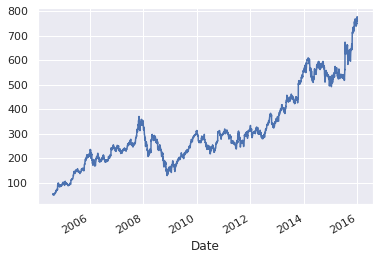

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

goog.plot()

### 5.1. 重新取样与频率转换

处理时间序列数据时，经常需要按照新的频率（更高频率、更低频率）对数据进行重新取样。  
你可以通过 `resample()` 方法解决这个问题，或者用更简单的 `asfreq()` 方法。  
这两个方法的主要差异在于，`resample()` 方法是以**数据累计**（`data aggregation`）为基础，而 `asfreq()` 方法是以**数据选择**（`data selection`）为基础。

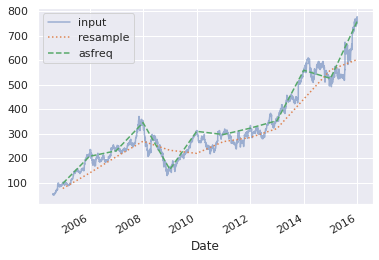

In [32]:
# 用两种方法对数据进行向后取样（down-sample），这里用年末（'BA'，最后一个工作日）对数据进行重新取样
# 注意这两种取样方法的差异：在每个数据点上，resample 反映的是上一年的均值，而 asfreq 反映的是上一年最后一个工作日的收盘价
goog.plot(alpha=0.5, style='-')
goog.resample('BA').mean().plot(style=':')
goog.asfreq('BA').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'], loc='upper left');

在进行向前取样（`up-sampling`）时，`resample()` 与 `asfreq()` 的用法大体相同，不过重新取样有许多种配置方式。  
操作时，两种方法都默认将向前取样作为缺失值处理，也就是说在里面填充 NaN。  
与前面介绍过的 `pd.fillna()` 函数类似，`asfreq()` 有一个 `method` 参数可以设置填充缺失值的方式。  

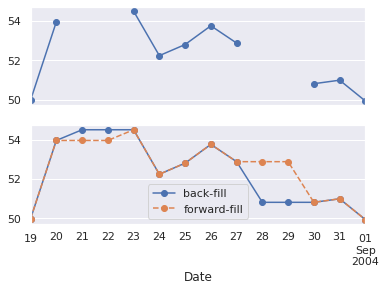

In [33]:
# 下面将对工作日数据按天进行重新取样（即包含周末），结果如图所示
# 上面那幅图是原始数据：非工作日的股价是缺失值，所以不会出现在图上
# 而下面那幅图通过向前填充与向后填充这两种方法填补了缺失值
fig, ax = plt.subplots(2, sharex=True)
data = goog.iloc[:10]

data.asfreq('D').plot(ax=ax[0], marker='o')

data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"])

### 5.2. 时间迁移

另一种常用的时间序列操作是对数据按时间进行迁移。`Pandas` 有两种解决这类问题的方法：`shift()` 和 `tshift()`。  
简单来说，`shift()` 就是**迁移数据**，而 `tshift()` 就是**迁移索引**。两种方法都是按照频率代码进行迁移。

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: tshift is deprecated and will be removed in a future version. Please use shift instead.
  # This is added back by InteractiveShellApp.init_path()


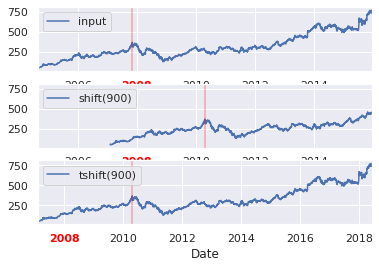

In [34]:
# 我们将用 shift() 和 tshift() 这两种方法让数据迁移 900 天，如图所示
# 我们会发现，shift(900) 将数据向前推进了 900 天，这样图形中的一段就消失了（最左侧就变成了缺失值）
# 而 tshift(900) 方法是将时间索引值向前推进了 900 天
fig, ax = plt.subplots(3, sharey=True)

# 对数据应用时间频率，用向后填充解决缺失值
goog = goog.asfreq('D', method='pad')

goog.plot(ax=ax[0])
goog.shift(900).plot(ax=ax[1])
goog.tshift(900).plot(ax=ax[2])  # FutureWarning: tshift is deprecated and will be removed in a future version. Please use shift instead.

# 设置图例与标签
local_max = pd.to_datetime('2007-11-05')
offset = pd.Timedelta(900, 'D')

ax[0].legend(['input'], loc=2)
ax[0].get_xticklabels()[2].set(weight='heavy', color='red')
ax[0].axvline(local_max, alpha=0.3, color='red')

ax[1].legend(['shift(900)'], loc=2)
ax[1].get_xticklabels()[2].set(weight='heavy', color='red')
ax[1].axvline(local_max + offset, alpha=0.3, color='red')

ax[2].legend(['tshift(900)'], loc=2)
ax[2].get_xticklabels()[1].set(weight='heavy', color='red')
ax[2].axvline(local_max + offset, alpha=0.3, color='red');

这类迁移方法的常见使用场景就是计算数据在不同时段的差异。

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: tshift is deprecated and will be removed in a future version. Please use shift instead.
  


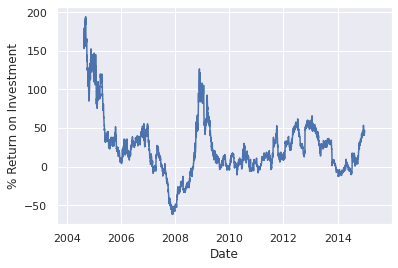

In [35]:
# 我们可以用迁移后的值来计算 Google 股票一年期的投资回报率，如图所示
ROI = 100 * (goog.tshift(-365) / goog - 1)
ROI.plot()
plt.ylabel('% Return on Investment');

### 5.3. 移动时间窗口

`Pandas` 处理时间序列数据的第 3 种操作是移动统计值（`rolling statistics`）。  
这些指标可以通过 `Series` 和 `DataFrame` 的 `rolling()` 属性来实现，它会返回与 `groupby` 操作类似的结果（详情请参见 3.9 节）。  
移动视图（`rolling view`）使得许多累计操作成为可能。

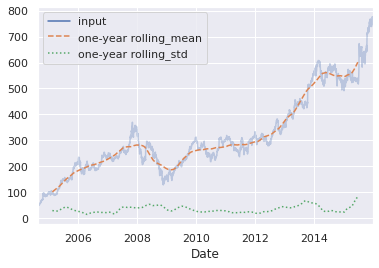

In [36]:
# 可以通过下面的代码获取 Google 股票收盘价的一年期移动平均值和标准差，如图所示
rolling = goog.rolling(365, center=True)
data = pd.DataFrame({'input': goog,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)

## 6. 案例：美国西雅图自行车统计数据的可视化

In [37]:
# !curl -o ../data/FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD  # 数据不断更新，这份数据下载于2021-09-22

data = pd.read_csv('../data/FremontBridge.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0


In [38]:
# data.columns = ['West', 'East']
# data['Total'] = data.eval('West + East')           # 书中给出实例时的数据没有total列
data.columns = ['Total', 'West', 'East']             # 简化列名
data.head()

,Total,West,East
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0


In [39]:
data.dropna().describe()

,Total,West,East
count,144352.000000,144352.000000,144352.000000
mean,111.188013,50.529241,60.658772
std,141.260941,65.050403,87.812023
min,0.000000,0.000000,0.000000
25%,14.000000,6.000000,7.000000
50%,60.000000,28.000000,30.000000
75%,146.000000,68.000000,75.000000
max,1097.000000,698.000000,850.000000


### 6.1. 数据可视化

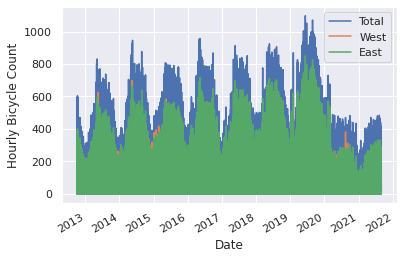

In [40]:
%matplotlib inline
import seaborn; seaborn.set()

data.plot()
plt.ylabel('Hourly Bicycle Count');  # 2021年数据骤减是因为新冠疫情？

Text(0, 0.5, 'Weekly bicycle count')

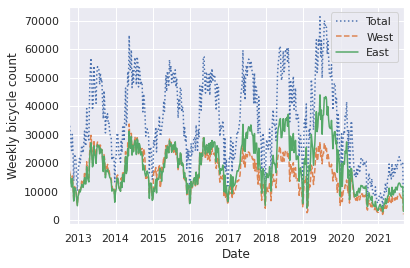

In [41]:
# 通过重新取样将数据转换成更大的颗粒度，比如按周累计，如图所示
weekly = data.resample('W').sum()
weekly.plot(style=[':', '--', '-'])
plt.ylabel('Weekly bicycle count')  # 这就显示出一些季节性的特征了。正如你所想，夏天骑自行车的人比冬天多，而且某个季节中每一周的自行车数量也在变化，可能与天气有关

另一种对数据进行累计的简便方法是用 `pd.rolling_mean()` 函数求移动平均值。

Text(0, 0.5, 'mean of 30 days count')

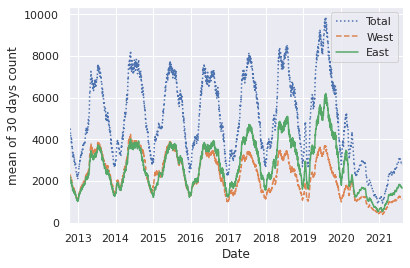

In [42]:
# 计算数据的 30 日移动均值，并让图形在窗口居中显示（center=True），如图所示
daily = data.resample('D').sum()
daily.rolling(30, center=True).mean().plot(style=[':', '--', '-'])
plt.ylabel('mean of 30 days count')

由于窗口太小，现在的图形还不太平滑。我们可以用另一个移动均值的方法获得更平滑的图形，例如高斯分布时间窗口。

<AxesSubplot:xlabel='Date'>

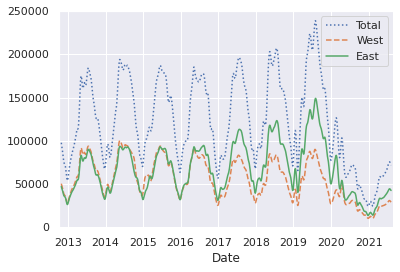

In [43]:
# 设置窗口的宽度（选择 50 天）和窗口内高斯平滑的宽度（选择 10 天）
daily.rolling(50, center=True, win_type='gaussian').sum(std=10).plot(style=[':', '--', '-'])

### 6.2. 深入挖掘数据

<AxesSubplot:xlabel='time'>

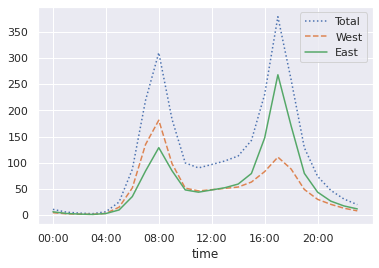

In [44]:
# 虽然我们已经从上图的平滑数据图观察到了数据的总体趋势，但是它们还隐藏了一些有趣的特征。
# 例如，我们可能希望观察单日内的小时均值流量，这可以通过 GroupBy（详情请参见 3.9 节）操作来解决，如图所示
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-'])

<AxesSubplot:>

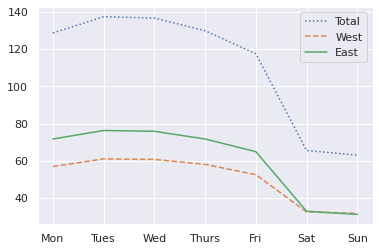

In [45]:
# 小时均值流量呈现出十分明显的双峰分布特征，早间峰值在上午 8 点，晚间峰值在下午 5 点。这充分反映了过桥上下班往返自行车流量的特征。
# 进一步分析会发现，桥西的高峰在早上（因为人们每天会到西雅图的市中心上班），而桥东的高峰在下午（下班再从市中心离开）。
# 我们可能还会对周内每天的变化产生兴趣，这时依然可以通过一个简单的 groupby 来实现，如图所示
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-'])

In [46]:
# 工作日与周末的自行车流量差十分显著，周一到周五通过的自行车差不多是周六、周日的两倍。
# 看到这个特征之后，让我们用一个复合 groupby 来观察一周内工作日与双休日每小时的数据。
# 用一个标签表示双休日和工作日的不同小时：
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()

<AxesSubplot:title={'center':'Weekends'}, xlabel='time'>

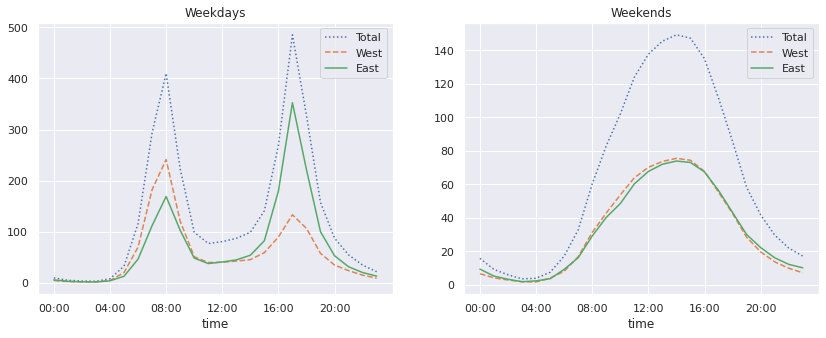

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
# by_time.ix['Weekday'].plot(ax=ax[0], title='Weekdays', xticks=hourly_ticks, style=[':', '--', '-'])  # AttributeError: 'DataFrame' object has no attribute 'ix'
# by_time.ix['Weekend'].plot(ax=ax[1], title='Weekends', xticks=hourly_ticks, style=[':', '--', '-'])  # AttributeError: 'DataFrame' object has no attribute 'ix'
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays', xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends', xticks=hourly_ticks, style=[':', '--', '-'])

# 结果很有意思，我们会发现工作日的自行车流量呈双峰通勤模式（bimodal commute pattern），而到了周末就变成了单峰娱乐模式（unimodal recreational pattern）。
# 假如继续挖掘数据应该还会发现更多有趣的信息，比如研究天气、温度、一年中的不同时间以及其他因素对人们通勤模式的影响。